In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import collections

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# Timeline

In [4]:
_ = (
    pd.read_csv(
        'rehydrated_tweets_count_by_day.csv',
        parse_dates=['day'],
        index_col=['day', 'lang']
   )
    ['count']
    .unstack('lang', fill_value=0)
)

_['total'] = _.sum(axis=1)
_ = _[['lv', 'ru', 'en', 'total']]

timeline = _

In [5]:
timeline.head()

lang,lv,ru,en,total
day,,,,
2017-04-15,1304,362,134,1969
2017-04-16,1462,336,189,2218
2017-04-17,1353,286,182,2019
2017-04-18,2767,378,319,3664
2017-04-19,3134,443,312,4123


In [6]:
'Average tweet number per day: {:.0f}'.format(timeline['total'].mean())

'Average tweet number per day: 3165'

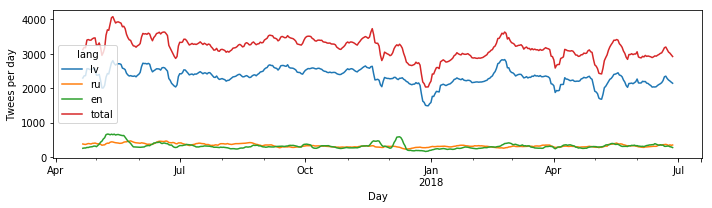

In [7]:
_ = (
    timeline
    .rolling(window=7).mean()
    .plot(figsize=(10, 3))
)

_.set(xlabel='Day', ylabel='Twees per day')


_.figure.tight_layout()
_.figure.savefig('rehydrated_tweets_count_by_day.pdf')

# Source statistics

In [8]:
sources = (
    pd.read_csv(
        'rehydrated_tweets_source_counts.csv',
        index_col=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
        ],
        usecols=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
            'source_lang_count', 'source_lang_share'
        ],
    )
    .unstack('lang', fill_value=0)
)

In [9]:
sources = (
    sources.reorder_levels([1, 0], axis=1)
    .reset_index()
    .set_index('source_pretty').sort_values('total_count', ascending=False)[
        [
            'total_count', 'total_share', 'tracked_source_share',
            'lv', 'ru', 'en',
            'other_lang_count', 'other_lang_share',
        ]
    ]
    .sort_values('total_count', ascending=False)
)

In [10]:
sources

lang                total_count total_share tracked_source_share  \
                                                                   
source_pretty                                                      
Twitter Web Client       478544       34.4%                51.6%   
Twitter for Android      231277       16.6%                 8.2%   
Twitter for iPhone       207047       14.9%                14.1%   
TweetDeck                105703        7.6%                91.8%   
TVNET Login               58632        4.2%                96.7%   
dlvr.it                   45980        3.3%                98.4%   
Facebook                  36885        2.7%                95.1%   
Foursquare                31052        2.2%                 0.0%   
Instagram                 24954        1.8%                 1.8%   
SKATIES                   23237        1.7%                98.0%   

lang                               lv                                  ru  \
                    source_lang_count source_lang_share source_lang_count   
source_pretty                                                               
Twitter Web Client             391414             81.8%             15255   
Twitter for Android            155846             67.4%             22776   
Twitter for iPhone             125292             60.5%             33187   
TweetDeck                      103595             98.0%                75   
TVNET Login                     26624             45.4%             31320   
dlvr.it                         45444             98.8%               134   
Facebook                        13948             37.8%             21170   
Foursquare                      24557             79.1%               219   
Instagram                        8892             35.6%              2465   
SKATIES                         23221             99.9%                 0   

lang                                                 en                    \
                    source_lang_share source_lang_count source_lang_share   
source_pretty                                                               
Twitter Web Client               3.2%             40606              8.5%   
Twitter for Android              9.8%             35271             15.3%   
Twitter for iPhone              16.0%             32105             15.5%   
TweetDeck                        0.1%              1488              1.4%   
TVNET Login                     53.4%                23              0.0%   
dlvr.it                          0.3%               129              0.3%   
Facebook                        57.4%               453              1.2%   
Foursquare                       0.7%              1895              6.1%   
Instagram                        9.9%              8310             33.3%   
SKATIES                             0                 0                 0   

lang                other_lang_count other_lang_share  
                                                       
source_pretty                                          
Twitter Web Client             31269             6.5%  
Twitter for Android            17384             7.5%  
Twitter for iPhone             16463             8.0%  
TweetDeck                        545             0.5%  
TVNET Login                      665             1.1%  
dlvr.it                          273             0.6%  
Facebook                        1314             3.6%  
Foursquare                      4381            14.1%  
Instagram                       5287            21.2%  
SKATIES                           16             0.1%

In [11]:
sources.to_latex('figures/rehydrated_tweets_source_counts.tex')

# Users

In [12]:
rehydrated_tweets_user_tweet_count = pd.read_csv('rehydrated_tweets_user_tweet_count.csv', squeeze=True)

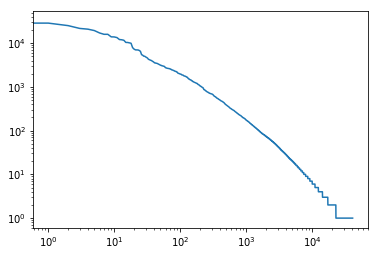

In [13]:
rehydrated_tweets_user_tweet_count.plot.line(logx=True, logy=True);

In [14]:
_total = rehydrated_tweets_user_tweet_count.shape[0]
_at_least_50 = (rehydrated_tweets_user_tweet_count >= 50).sum()
print(
    f'Total users: {_total}\n'
    f'Users with at least 50 tweets: {_at_least_50} ({{:.1%}})'.format(_at_least_50 / _total)
)

Total users: 41256
Users with at least 50 tweets: 2773 (6.7%)


In [15]:
active_tweets = rehydrated_tweets_user_tweet_count[rehydrated_tweets_user_tweet_count >= 50].sum()
total_tweets = rehydrated_tweets_user_tweet_count.sum()
assert timeline['total'].sum() == total_tweets
_ = active_tweets / total_tweets
f'Total tweets by active users: {active_tweets}, {_:.1%}. Total tweets: {total_tweets}'

'Total tweets by active users: 1203145, 86.6%. Total tweets: 1389483'

# Language usage 

In [16]:
rehydrated_tweets_language_counts = (
    pd.read_csv('rehydrated_tweets_language_counts.csv', index_col='lang')
)

In [17]:
rehydrated_tweets_language_counts

,count
lang,
en,139003
lv,1022338
ru,145103


In [18]:
(
    (rehydrated_tweets_language_counts / timeline['total'].sum())
    .style.format({'count': '{:.1%}'})
)

,count
lang,
en,10.0%
lv,73.6%
ru,10.4%


In [19]:
_ = (timeline['total'].sum() - rehydrated_tweets_language_counts.sum())[0]

__ = _ / rehydrated_tweets_language_counts.sum()[0]
f'{_}, {__:.1%}'

'83039, 6.4%'

In [20]:
_ = pd.read_csv('rehydrated_tweets_lang_usage.csv', index_col='rnum')

_['Language Uniformity Score'] = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

lang_usage = _

In [21]:
'Users with at least 50 users (should match the value above): {}'.format(lang_usage.shape[0])

'Users with at least 50 users (should match the value above): 2773'

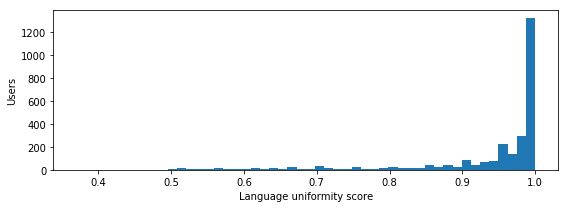

In [22]:
_ = lang_usage['Language Uniformity Score'].plot.hist(bins=50, figsize=(8, 3))

_.set(xlabel="Language uniformity score", ylabel="Users")
_.figure.tight_layout()

_.figure.savefig('rehydrated_tweets_lang_usage.pdf')

In [23]:
_ = pd.read_csv(
    'milajevs-bucc17-screen_names-languages.csv',
    index_col='Screen name',
    usecols=['Screen name', 'Latvian', 'Russian', 'English'],
).fillna(0).astype(int)

_.columns = ['lv', 'ru', 'en']

bucc17_uniformity_score = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

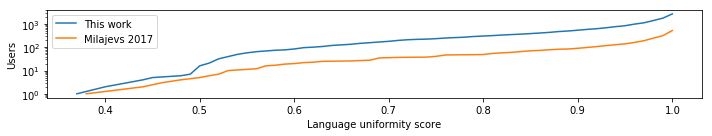

In [24]:
_ = (
    lang_usage['Language Uniformity Score'].value_counts().sort_index().cumsum().rename('This work')
    .plot(logx=False, logy=True, figsize=(10, 2), legend=True)
)

bucc17_uniformity_score.value_counts().sort_index().cumsum().rename('Milajevs 2017').plot(legend=True)

_.set(xlabel='Language uniformity score', ylabel='Users')
_.figure.tight_layout()

_.figure.savefig('uniformity_score.pdf')

In [25]:
lang_usage.sort_values('Language Uniformity Score').head()

,lv,ru,en,total,Language Uniformity Score
rnum,,,,,
2012,13,16,14,74,0.37
1598,16,20,14,97,0.40
2380,26,8,25,60,0.44
462,78,135,93,439,0.44
840,48,75,42,218,0.45


# Language preference

## Monolingual

In [26]:
monolingual = (
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] == 0).sum(axis='columns') == 2
    ]
    [['lv', 'ru', 'en']] > 0
).sum(axis='rows')

In [27]:
'Monoligual users: {}'.format(monolingual.sum())

'Monoligual users: 793'

In [28]:
pd.DataFrame(
    {
        'count': monolingual,
        'share': (monolingual / monolingual.sum()).round(3),
    }
)

,count,share
lv,635,0.801
ru,40,0.050
en,118,0.149


## Multilingual

In [29]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] > 0).sum(axis='columns') > 1
    ]
    [['lv', 'ru', 'en']]
    .replace(0, np.nan)
    .rank(axis='columns', method='min', ascending=False)
    .apply(lambda c: c.value_counts(), axis='rows')
)

,lv,ru,en
1.0,1496,222,252
2.0,299,160,1550
3.0,74,229,96


# Topics

In [30]:
relevance_judgments_count_by_day = (
    pd.read_csv(
        'relevance_judgments_count_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )['count']
    .unstack('topic_id', fill_value=0)
)

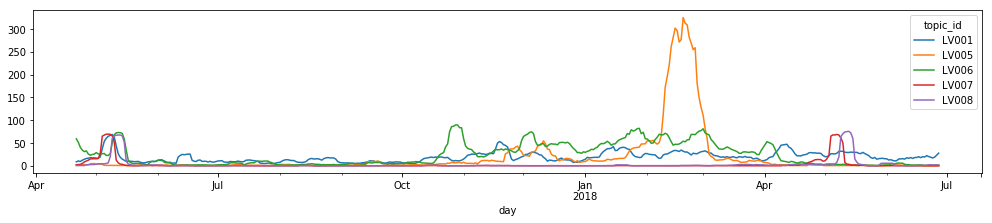

In [31]:
(
    relevance_judgments_count_by_day[
        ['LV001', 'LV005', 'LV006', 'LV007', 'LV008']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

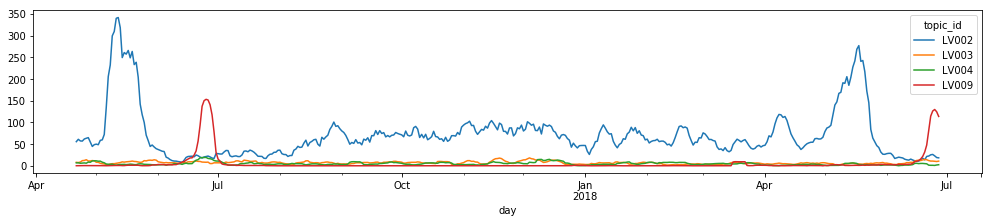

In [32]:
(
    relevance_judgments_count_by_day[['LV002', 'LV003', 'LV004', 'LV009']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

In [33]:
_ = (
    pd.read_csv(
        'relevance_judgments_lang_pref_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )
)

_.columns = pd.MultiIndex.from_tuples(
    [
        ('Counts', 'Total'),
        ('Counts', 'lv, ru, en'),

        ('Tweets', 'lv'),
        ('Tweets', 'ru'),
        ('Tweets', 'en'),

        ('Users', 'lv'),
        ('Users', 'ru'),
        ('Users', 'en'),
    ],
    names=['Type', 'Language']
)
relevance_judgments_lang_pref_by_day = _

In [34]:
relevance_judgments_lang_pref_by_day.head()

Type                Counts            Tweets           Users           
Language             Total lv, ru, en     lv   ru   en    lv   ru    en
day        topic_id                                                    
2017-04-16 LV001         8          8    1.0  0.0  0.0  0.99  0.0  0.01
2017-04-17 LV001         1          1    1.0  0.0  0.0  0.81  0.0  0.19
2017-04-18 LV001        12         12    1.0  0.0  0.0  0.98  0.0  0.02
2017-04-19 LV001        15         15    1.0  0.0  0.0  0.88  0.0  0.12
2017-04-20 LV001        11         10    1.0  0.0  0.0  1.00  0.0  0.00

In [35]:
relevance_judgments_lang_pref_by_day['Counts', 'Total'].groupby(level='topic_id').sum()

topic_id
LV001     7363
LV002    26691
LV003     2954
LV004     2042
LV005     7215
LV006     9360
LV007     1147
LV008     1197
LV009     2191
LV010      958
LV011      746
LV012     3489
LV013     1395
LV014      479
LV015      197
LV016      209
Name: (Counts, Total), dtype: int64

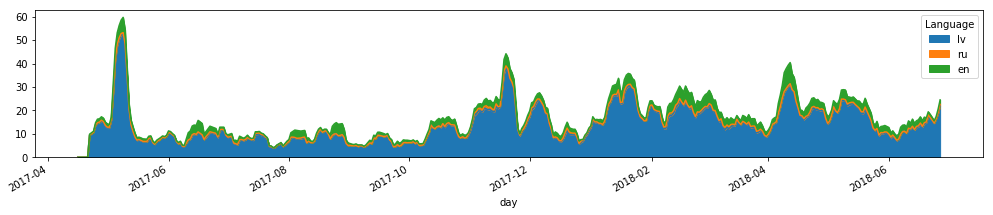

In [36]:
_ = relevance_judgments_lang_pref_by_day.loc[(slice(None), 'LV001'), :].reset_index('topic_id')

(
    _['Users']
    .multiply(
        _['Counts', 'lv, ru, en'],
        axis='rows',
    )
    .rolling(window=7).mean()
    .plot.area(figsize=(17, 3))
);

## Topics 2

In [37]:
_ = pd.read_csv(
    'relevance_judgments_lang_pref.csv',
    index_col=['topic_id', 'day', 'tweet_lang'],
    parse_dates=['day']
)

relevance_judgments_lang_pref = _

In [38]:
relevance_judgments_lang_pref.loc[['LV005']].head()

r_lv  r_ru  r_en
topic_id day        tweet_lang                  
LV005    2017-04-17 lv          1.00   0.0  0.00
                    lv          1.00   0.0  0.00
                    lv          0.98   0.0  0.01
         2017-04-18 lv          1.00   0.0  0.00
         2017-04-19 lv          1.00   0.0  0.00

In [39]:
_ = (
    relevance_judgments_lang_pref
    .groupby(level=['topic_id', 'tweet_lang']).size()
    .unstack('tweet_lang', fill_value=0)
    [['lv', 'ru', 'en']]
)

_total = _.sum(axis='columns')

__ = _.divide(_total, axis='rows')

__['total'] = _total
__.style.format({'lv': '{:.1%}', 'ru': '{:.1%}', 'en': '{:.1%}'})

__.to_latex('figures/topic_lang_counts.tex', float_format='{:.1%}'.format)

__

tweet_lang,lv,ru,en,total
topic_id,,,,
LV001,0.872349,0.017764,0.109887,7262
LV002,0.947007,0.024860,0.028133,25664
LV003,0.890736,0.068205,0.041059,2947
LV004,0.856722,0.046614,0.096663,2038
LV005,0.953653,0.041336,0.005010,7185
LV006,0.861843,0.098054,0.040103,9301
LV007,0.980702,0.019298,0.000000,1140
LV008,0.853762,0.129332,0.016906,1183
LV009,0.871012,0.078595,0.050393,2163


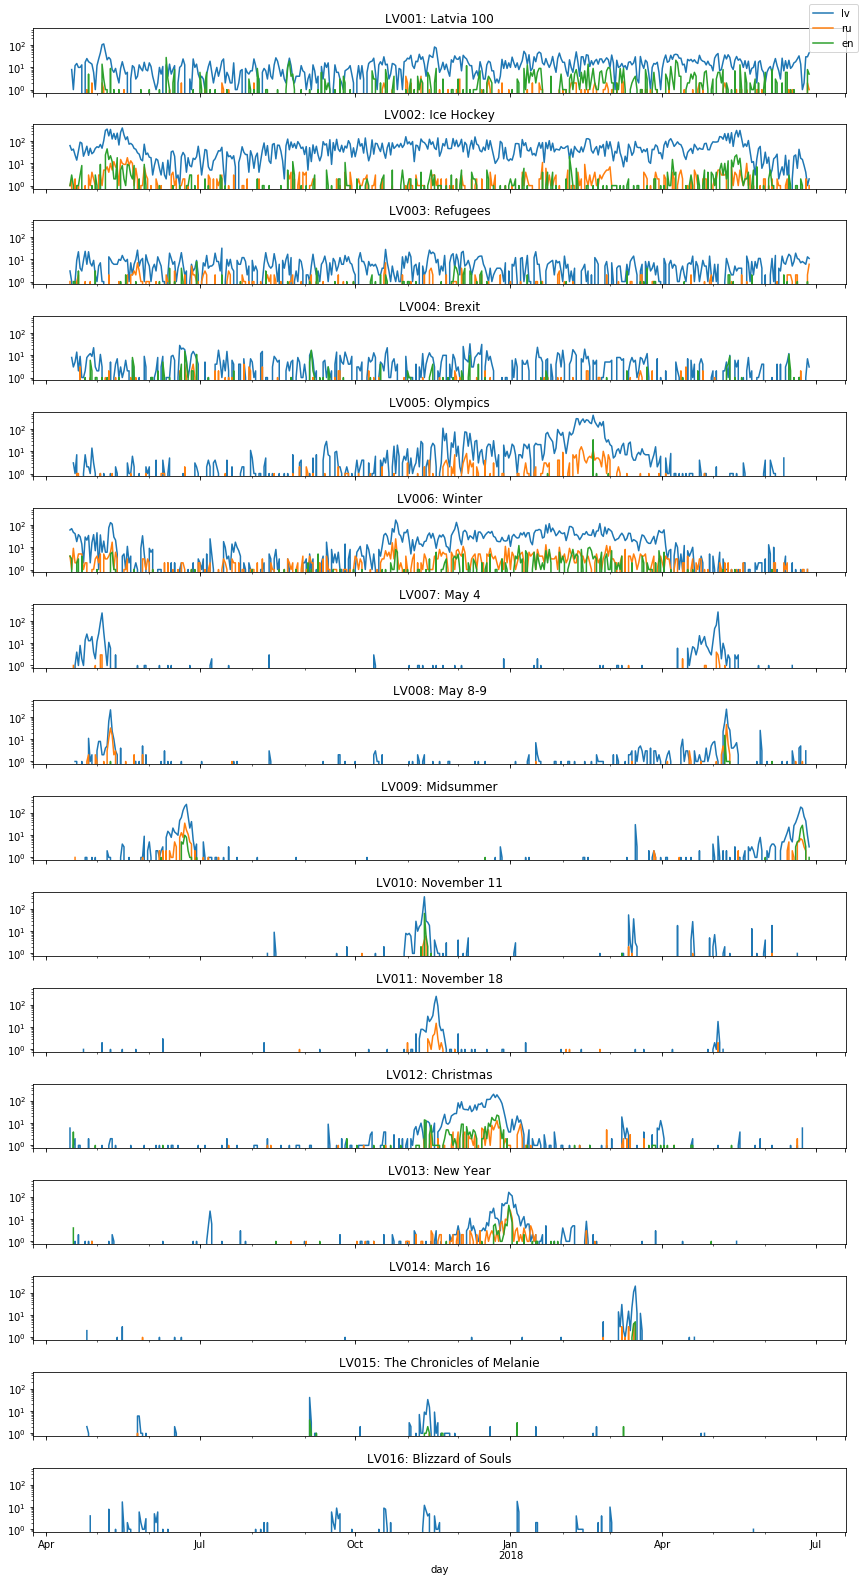

In [40]:
_data = (
    relevance_judgments_lang_pref
    .groupby(level=['topic_id', 'day' ,'tweet_lang']).size()
    .unstack('tweet_lang', fill_value=0)
    [['lv', 'ru', 'en']]
)


topics = collections.OrderedDict(
    [

        ('LV001', 'Latvia 100'),
        ('LV002', 'Ice Hockey'),
        ('LV003', 'Refugees'),
        ('LV004', 'Brexit'),
        ('LV005', 'Olympics'),

        ('LV006', 'Winter'),

        ('LV007', 'May 4'),
        ('LV008', 'May 8-9'),
        ('LV009', 'Midsummer'),
        ('LV010', 'November 11'),
        ('LV011', 'November 18'),
        ('LV012', 'Christmas'),
        ('LV013', 'New Year'),
        ('LV014', 'March 16'),

        ('LV015', 'The Chronicles of Melanie'),
        ('LV016', 'Blizzard of Souls'),
 
     ]
)

fig, axs = plt.subplots(len(topics), 1, sharex=True, sharey=True, figsize=(12, 22))

axs = axs.flatten()


for (topic, topic_title), ax in zip (topics.items(), axs):

    _ = (
        _data.loc[topic]
        .resample('1d', level='day').sum()
        .plot.line(ax=ax, logy=True, legend=False, title=f'{topic}: {topic_title}')
    );
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

fig.tight_layout()
fig.savefig('topic_timeline.pdf')

# Topic overlap

In [41]:
relevance_judgments_topic_overlap = (
    pd.read_csv('relevance_judgments_topic_overlap.csv')
    .groupby(['topic1', 'title1', 'topic2']).size().unstack('topic2', fill_value='')
)

In [42]:
relevance_judgments_topic_overlap

,topic2,LV001,LV002,LV003,LV004,LV005,LV006,LV007,LV008,LV009,LV010,LV011,LV012,LV013,LV014,LV015,LV016
topic1,title1,,,,,,,,,,,,,,,,
LV001,Latvia 100,8336,17,13,,17,2,118,18,14,14,38,7,6,,8,4
LV002,Ice Hockey,,30733,,,383,25,26,1,7,12,1,32,9,,,
LV003,Refugees,,,3143,30,,,,,2,,,11,1,,,
LV004,Brexit,,,,2141,,1,,,,,,,2,,,
LV005,Olympics,,,,,8323,12,,,,,,2,,,,
LV006,Winter,,,,,,10517,1,6,6,,10,238,42,,,
LV007,May 4,,,,,,,1330,8,,2,6,,,,,
LV008,May 8-9,,,,,,,,1376,1,1,,,,4,,
LV009,Midsummer,,,,,,,,,2596,,,3,1,1,,


In [43]:
sns.heatmap(
    relevance_judgments_topic_overlap,
    annot=True, fmt='d', cmap='Blues',
);

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## 